# USB RS232 FPGA PID DDS PCB

Import packages:

In [1]:
import pyvisa
import time
import matplotlib.pyplot as plt
import matplotlib.patches as plt_patches
from tqdm import tqdm_notebook
import numpy as np
import h5py

### HDF for data storage

Open the data file with read/write append access:

In [93]:
f = h5py.File('data.hdf5', 'a')

### Connecting to external devices

In [150]:
rm = pyvisa.ResourceManager()
print(rm.list_resources())

# FPGA board
instr = rm.open_resource("ASRL17::INSTR")
instr.baud_rate = 115200
instr.end_input = pyvisa.constants.SerialTermination.none

# # signal generator
siglent = None
# siglent = rm.open_resource('USB0::0xF4EC::0x1103::SDG1XCAD2R3284::INSTR')
# print(siglent.query('*IDN?'))

# oscilloscope
scope = rm.open_resource('USB0::0x1AB1::0x04CE::DS1ZA204519116::INSTR')
print(scope.query('*IDN?'))

('USB0::0x1AB1::0x04CE::DS1ZA204519116::INSTR', 'ASRL8::INSTR', 'ASRL13::INSTR', 'ASRL16::INSTR', 'ASRL17::INSTR')
RIGOL TECHNOLOGIES,DS1104Z,DS1ZA204519116,00.04.04.SP3



Close the devices after they are no longer needed:

In [149]:
for dev in [instr, siglent, scope]:
    try:
        dev.close()
    except Exception as err:
        print(err)

'NoneType' object has no attribute 'close'


### Testing RS232 communication

Write a character, read a character, and compare if they are the same:

In [ ]:
while True:
    for i in range(128):
        instr.write_raw(bytes(chr(i), encoding='ascii'))
        time.sleep(.05)
        read_byte = instr.read_bytes(1)
        read_i = int.from_bytes(read_byte, byteorder='big')
        if i != read_i:
            print(i, " != ", read_i)
            break

Empty the serial buffer:

In [11]:
try:
    while True:
        instr.read_bytes(1)
except pyvisa.VisaIOError:
    pass

Define and test function to set the value of the `F` outputs:

In [8]:
def set_F(val):
    # sanity check of parameter input
    if val<0 or val>7:
        print("ERROR: Parameter out of range.")
        return
    
    # write the command and data
    instr.write_raw('F')
    instr.write_raw(bytes(bytearray([val])))
    
set_F(0+4)

### PID parameters

Define functions to set and read PID parameters:

In [17]:
def set_error_invert(val):
    if type(val) != bool:
        raise TypeError
    
    instr.write_raw('N')
    instr.write_raw(bytes(bytearray([int(val)])))
    
def set_PID_param(param, MSB, LSB):
    instr.write_raw(param)
    instr.write_raw(bytes(bytearray([LSB])))
    instr.write_raw(bytes(bytearray([MSB])))

def set_PID_param2(param, val):
    instr.write_raw(param)
    LSB = int(val % 256)
    MSB = int(val / 256)
    instr.write_raw(bytes(bytearray([LSB])))
    instr.write_raw(bytes(bytearray([MSB])))
    
def read_PID_param(param):
    instr.write_raw(param)
    return instr.read_bytes(2)

Set the PID parameters to some default values:

In [149]:
set_error_invert(False)
set_PID_param2('P', 0)
set_PID_param2('I', 1)
set_PID_param2('S', 20000)

Define and test a function to read ADC data:

In [351]:
def read_ADC_data():
    # request data
    instr.write_raw('d')
    
    # read raw data
    raw_result = instr.read_bytes(2)
    
    # convert bytes to integer
    int_result = int.from_bytes(raw_result, byteorder='big', signed=False)
    
    return int_result

read_ADC_data()

206

Define a function to read the 4-byte outputs (accumulator, error, and output):

In [11]:
def read_PID_output(output="accum."):
    # request data
    if output == "accum.":
        instr.write_raw('a')
    elif output == "error":
        instr.write_raw('e')
    elif output == "out":
        instr.write_raw('o')
    
    # read raw data
    raw_result = instr.read_bytes(4)
    
    # convert bytes to integer
    if output == "error":
        int_result = int.from_bytes(raw_result, byteorder='big', signed=True)
    else:
        int_result = int.from_bytes(raw_result, byteorder='big', signed=False)
    
    return int_result

Test the function by reading all three values:

In [12]:
def read_all_PID_outs():
    for output in ["accum.", "error", "out"]:
        val = read_PID_output(output)
        print(output, "\t= ", val, " = ", round(100*val/4294967295, 2), "%")
        
read_all_PID_outs()

accum. 	=  492789502  =  11.47 %
error 	=  16286  =  0.0 %
out 	=  0  =  0.0 %


Read the three values many times, and plot the result:

In [42]:
# collect data
acc_arr, err_arr, out_arr = [], [], []
for i in tqdm_notebook(range(200)):
    acc_arr.append(read_PID_output("accum."))
    err_arr.append(read_PID_output("error"))
    out_arr.append(read_PID_output("out"))
    
# store data to HDF
dset = f.create_dataset("sample PID outputs", data=[acc_arr, err_arr, out_arr])
dset.attrs['row_names'] = "acc[31:0], error[31:0], out[31:0]"
dset.attrs['units'] = "%, %, %"
dset.attrs['P'] = (0, 100)
dset.attrs['I'] = (0, 10)
dset.attrs['S'] = (150, 255)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 93.11it/s]


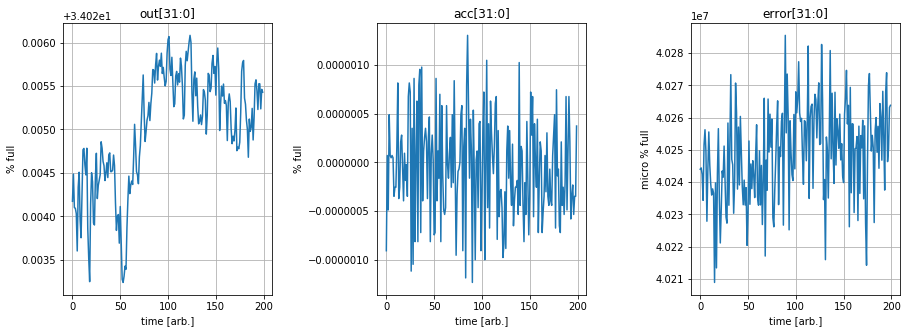

In [45]:
# format
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
for ax in [ax1, ax2, ax3]:
    ax.grid()
plt.subplots_adjust(wspace=.5)

# labels
ax1.set_title("out[31:0]")
ax1.set_ylabel("% full")
ax1.set_xlabel("time [arb.]")
ax2.set_title("acc[31:0]")
ax2.set_ylabel("% full")
ax2.set_xlabel("time [arb.]")
ax3.set_title("error[31:0]")
ax3.set_ylabel("micro % full")
ax3.set_xlabel("time [arb.]")

# get data from HDF file
dset = f["sample PID outputs"]
out_arr, acc_arr, err_arr = dset[0], dset[1], dset[2]

# plot data
ax1.plot(out_arr)
ax2.plot(acc_arr)
ax3.plot(1000000*np.array(err_arr))

### Signal generator and scope

Define functions to set the signal generator frequency and amplitude, and to set scope horizontal scale, and read measurements therefrom:

In [96]:
def set_frequency(freq):
    siglent.write("C1:BSWV FRQ,"+str(freq))
    
def set_highlow(high=1.0, low=0.0):
    siglent.write("C1:BSWV HLEV,"+str(high))
    siglent.write("C1:BSWV LLEV,"+str(low))

def set_scope_horizontal_scale(scale):
    scope.write(":TIM:MAIN:SCAL "+str(scale))
    
def read_scope(item="VAVG", ch="CHAN1"):
    # obtain measurement
    try:
        val = scope.query(":MEAS:ITEM? "+item+","+ch)
    except pyvisa.VisaIOError:
        return np.nan
    
    # convert to number
    try:
        return float(val[:-1])
    except ValueError:
        return np.nan

For example, we can set the signal generator to 50 kHz from 0V to 1V, set scope time/div to 5 microseconds, and read the average and RMS values of the scope channel 1:

In [125]:
set_frequency(50*1000)
set_highlow(1.0, 0.0)
set_scope_horizontal_scale(5e-6)
print(read_scope("VAVG", "CHAN1"))
print(read_scope("VRMS", "CHAN1"))

2.439899
2.441211


### ADC calibration

According to the [FPGA XADC user guide](https://www.xilinx.com/support/documentation/user_guides/ug480_7Series_XADC.pdf) (see Fig. 2-2 on page 26), the ADC is linear as follows:

<img src="ADC voltage vs number.png" alt="Drawing" style="width: 400px;"/>

However, on the [Cmod A7](https://reference.digilentinc.com/reference/programmable-logic/cmod-a7/reference-manual#analog_inputs) board the FPGA sees a voltage divider before its ADC inputs:

<img src="cmoda7_b_analog.png" alt="Drawing" style="width: 400px;"/>

So we expect that roughly 3.3V corresponds to the maximum measured value.

In [145]:
# start with lowest setpoint, and wait for it to settle
set_PID_param('S', 1, 0)
time.sleep(1)

# collect data
setpoint_arr, volts_arr = [], []
for i in tqdm_notebook(range(1,185)):
    setpoint_arr.append(i)
    set_PID_param('S', i, 0)
    time.sleep(0.2)
    volts_arr.append(read_scope("VAVG", "CHAN1"))
    
# store data to HDF
try:
    dset = f.create_dataset("setpoint vs voltage", data=[setpoint_arr, volts_arr])
except RuntimeError:
    dset = f["setpoint vs voltage"]
    dset[...] = [setpoint_arr, volts_arr]
dset.attrs['timestamp'] = time.time()
dset.attrs['row_names'] = "setpoint, VAVG"
dset.attrs['units'] = "raw integer, volts"
dset.attrs['P'] = (0, 100)
dset.attrs['I'] = (0, 10)

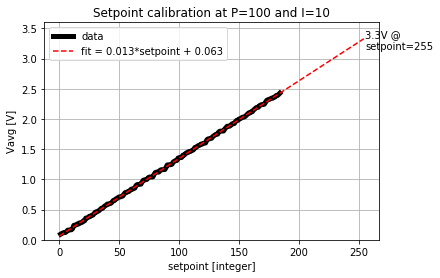

In [146]:
# get data from HDF file
dset = f["setpoint vs voltage"]
setpoint_arr, volts_arr = dset[0], dset[1]

# fit data to a straight line
fit = np.polyfit(setpoint_arr, volts_arr, 1)
fit_fn = np.poly1d(fit)
fit_setpoint = np.arange(0,255)

# plot labels
plt.title("Setpoint calibration at P="+str(dset.attrs["P"][1])+" and I="+str(dset.attrs["I"][1]))
plt.xlabel("setpoint [integer]")
plt.ylabel("Vavg [V]")
plt.text(255, 3.3, "3.3V @\nsetpoint=255", ha="left", va="center")

# plot data
plt.plot(setpoint_arr, volts_arr, label="data", lw=5, color="black")
plt.plot(fit_setpoint, fit_fn(fit_setpoint), color="red", ls="dashed",
         label="fit = "+str(round(fit[0],3))+"*setpoint + "+str(round(fit[1], 3)))

# format
plt.grid()
plt.ylim((0,3.6))
plt.legend();

Note that we cannot measure all the way up to the maximum value since the DAC only outputs approx. 2.4V max with all bits set to `HIGH`. However, extrapolating the fit, we see that it reaches approx. 3.3V at the maximum integer:

In [107]:
0.013*255 + 0.063

3.378

### PID's resilience to sine "noise"

Connecting a signal generator to the ADC input via a 10k resistor, we can see how well the PID can compensate for it as a function of the signal frequency and amplitude, or, alternatively, PID parameters.

In [172]:
set_PID_param('P', 0, 255)
set_PID_param('I', 50, 0)
set_PID_param('S', 150, 255)
set_highlow(4.0, 0.0)
set_frequency(1e3)
time.sleep(1)

freqs, VAVG_arr, VRMS_arr = [], [], []
for freq in tqdm_notebook(np.arange(1, 100e3, 1e2)):
    freqs.append(freq)
    set_scope_horizontal_scale(1/freq)
    set_frequency(freq)
    time.sleep(10/freq + 0.1)
    VAVG_arr.append(read_scope("VAVG", "CHAN1"))
    VRMS_arr.append(read_scope("VRMS", "CHAN2"))

In [173]:
# store data to HDF
try:
    dset = f.create_dataset("resilience vs freq3", data=[freqs, VAVG_arr, VRMS_arr])
except RuntimeError:
    dset = f["resilience vs freq3"]
    dset[...] = [freqs, VAVG_arr, VRMS_arr]
dset.attrs['timestamp'] = time.time()
dset.attrs['row_names'] = "freq, VAVG, VRMS"
dset.attrs['units'] = "Hz, V, V"
dset.attrs['P'] = (0, 255)
dset.attrs['I'] = (50, 0)
dset.attrs['S'] = (150, 255)
dset.attrs['noise high/low'] = (4.0, 0.0)

In [215]:
freq = 50e3
set_scope_horizontal_scale(1/freq)
set_PID_param('P', 1, 0)
set_PID_param('I', 50, 0)
set_PID_param('S', 150, 255)
set_highlow(4.0, 0.0)
set_frequency(freq)
time.sleep(1)

P_arr, VAVG_arr, VRMS_arr = [], [], []
for P in tqdm_notebook(range(0,150)):
    P_arr.append(P)
    set_PID_param('P', 1, P)
    time.sleep(10/freq + 0.1)
    VAVG_arr.append(read_scope("VAVG", "CHAN1"))
    VRMS_arr.append(read_scope("VRMS", "CHAN2"))
    
# store data to HDF
dset = f.create_dataset("resilience vs P2", data=[P_arr, VAVG_arr, VRMS_arr])
dset.attrs['timestamp'] = time.time()
dset.attrs['row_names'] = "P, VAVG, VRMS"
dset.attrs['units'] = "MSB, V, V"
dset.attrs['P'] = "(1, P)"
dset.attrs['I'] = (50, 0)
dset.attrs['S'] = (150, 255)
dset.attrs['freq'] = freq
dset.attrs['noise high/low'] = (4.0, 0.0)

In [255]:
freq = 50e3
set_scope_horizontal_scale(1/freq)
set_PID_param('P', 1, 40)
set_PID_param('I', 0, 0)
set_PID_param('S', 150, 255)
set_highlow(4.0, 0.0)
set_frequency(freq)
time.sleep(1)

I_arr, VAVG_arr, VRMS_arr = [], [], []
for I in tqdm_notebook(range(0,130)):
    I_arr.append(I)
    set_PID_param('I', I, 0)
    time.sleep(10/freq + 0.1)
    VAVG_arr.append(read_scope("VAVG", "CHAN1"))
    VRMS_arr.append(read_scope("VRMS", "CHAN2"))
    
# store data to HDF
dset = f.create_dataset("resilience vs I4", data=[I_arr, VAVG_arr, VRMS_arr])
dset.attrs['timestamp'] = time.time()
dset.attrs['row_names'] = "I, VAVG, VRMS"
dset.attrs['units'] = "MSB, V, V"
dset.attrs['P'] = (1, 40)
dset.attrs['S'] = (150, 255)
dset.attrs['freq'] = freq
dset.attrs['noise high/low'] = (4.0, 0.0)

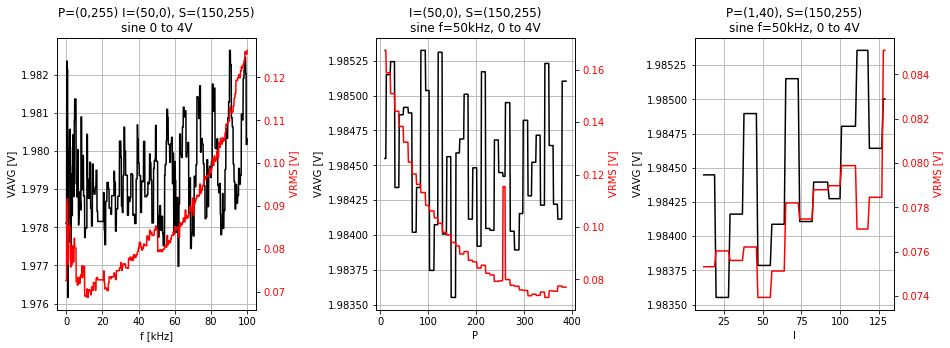

In [261]:
# axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1_b = ax1.twinx()
ax1_b.tick_params(axis='y', labelcolor="red")
ax2_b = ax2.twinx()
ax2_b.tick_params(axis='y', labelcolor="red")
ax3_b = ax3.twinx()
ax3_b.tick_params(axis='y', labelcolor="red")

# get data from HDF file
dset = f["resilience vs freq3"]
freqs, VAVG_arr, VRMS_arr = dset[0]/1000, dset[1], dset[2]
dset = f["resilience vs P"]
P_arr2, VAVG_arr2, VRMS_arr2 = dset[0], dset[1], dset[2]
dset = f["resilience vs P2"]
P_arr2 = np.append(P_arr2, 256+dset[0])
VAVG_arr2 = np.append(VAVG_arr2, dset[1])
VRMS_arr2 = np.append(VRMS_arr2, dset[2])
dset = f["resilience vs I4"]
I_arr3, VAVG_arr3, VRMS_arr3 = dset[0], dset[1], dset[2]

# labels
ax1.set_title("P=(0,255) I=(50,0), S=(150,255)\nsine 0 to 4V")
ax1.set_xlabel("f [kHz]")
ax1.set_ylabel("VAVG [V]")
ax1_b.set_ylabel("VRMS [V]", color="red")
ax2.set_title("I=(50,0), S=(150,255)\nsine f=50kHz, 0 to 4V")
ax2.set_xlabel("P")
ax2.set_ylabel("VAVG [V]")
ax2_b.set_ylabel("VRMS [V]", color="red")
ax3.set_title("P=(1,40), S=(150,255)\nsine f=50kHz, 0 to 4V")
ax3.set_xlabel("I")
ax3.set_ylabel("VAVG [V]")
ax3_b.set_ylabel("VRMS [V]", color="red")

# plot data
ax1.plot(freqs, VAVG_arr, color="black", label="VAVG")
ax1_b.plot(freqs, VRMS_arr, color="red", label="VRMS")
imax=-18
ax2.plot(P_arr2[10:imax], VAVG_arr2[10:imax], color="black", label="VAVG")
ax2_b.plot(P_arr2[10:imax], VRMS_arr2[10:imax], color="red", label="VRMS")
imin = 12
ax3.plot(I_arr3[imin:], VAVG_arr3[imin:], color="black", label="VAVG")
ax3_b.plot(I_arr3[imin:], VRMS_arr3[imin:], color="red", label="VRMS")

# format
for ax in [ax1, ax2, ax3]:
    ax.grid()
plt.subplots_adjust(wspace=.6);

In [273]:
# sine wave parameters
freq = 50e3
high = 4.0
low = 0.0

# PID parameters
P = 0
I = 0
S = 38655

set_scope_horizontal_scale(1/freq)
set_PID_param2('P', P)
set_PID_param2('I', I)
set_PID_param2('S', S)
set_highlow(high, low)
set_frequency(freq)
time.sleep(1)

P_arr, VAVG_arr, VRMS_arr = [], [], []
for P in tqdm_notebook(range(0,470)):
    P_arr.append(P)
    set_PID_param2('P', P)
    time.sleep(10/freq + 0.1)
    VAVG_arr.append(read_scope("VAVG", "CHAN1"))
    VRMS_arr.append(read_scope("VRMS", "CHAN2"))
    
# store data to HDF
dset = f.create_dataset("resilience vs P5", data=[P_arr, VAVG_arr, VRMS_arr])
dset.attrs['timestamp'] = time.time()
dset.attrs['row_names'] = "P, VAVG, VRMS"
dset.attrs['units'] = "integer, V, V"
dset.attrs['I'] = I
dset.attrs['S'] = S
dset.attrs['freq'] = freq
dset.attrs['noise high/low'] = (high, low)

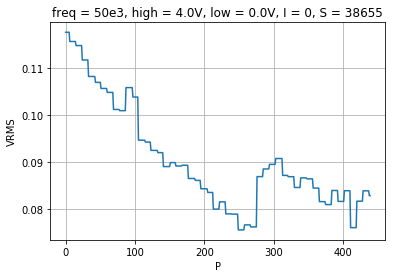

In [282]:
# get data from HDF file
dset = f["resilience vs P5"]
P_arr, VAVG_arr, VRMS_arr = dset[0], dset[1], dset[2]

# plot labels
plt.xlabel("P")
plt.ylabel("VRMS")
plt.title("freq = 50e3, high = 4.0V, low = 0.0V, I = 0, S = 38655")

# plot data
imax = -30
plt.plot(P_arr[:imax], VRMS_arr[:imax])

# format
plt.grid()

In [278]:
# sine wave parameters
freq = 50e3
high = 4.0
low = 0.0

# PID parameters
P = 250
I = 0
S = 38655

set_scope_horizontal_scale(1/freq)
set_PID_param2('P', P)
set_PID_param2('I', I)
set_PID_param2('S', S)
set_highlow(high, low)
set_frequency(freq)
time.sleep(1)

I_arr, VAVG_arr, VRMS_arr = [], [], []
for I in tqdm_notebook(range(0,470)):
    I_arr.append(I)
    set_PID_param2('I', I)
    time.sleep(10/freq + 0.1)
    VAVG_arr.append(read_scope("VAVG", "CHAN1"))
    VRMS_arr.append(read_scope("VRMS", "CHAN2"))
    
# store data to HDF
dset = f.create_dataset("resilience vs I5", data=[I_arr, VAVG_arr, VRMS_arr])
dset.attrs['timestamp'] = time.time()
dset.attrs['row_names'] = "I, VAVG, VRMS"
dset.attrs['units'] = "integer, V, V"
dset.attrs['P'] = P
dset.attrs['S'] = S
dset.attrs['freq'] = freq
dset.attrs['noise high/low'] = (high, low)

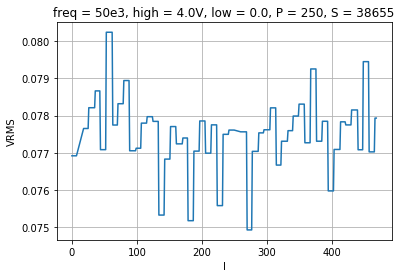

In [99]:
# get data from HDF file
dset = f["resilience vs I5"]
I_arr, VAVG_arr, VRMS_arr = dset[0], dset[1], dset[2]

# plot labels
plt.xlabel("I")
plt.ylabel("VRMS")
plt.title("freq = 50e3, high = 4.0V, low = 0.0, P = 250, S = 38655")

# plot data
plt.plot(I_arr[VRMS_arr<.09], VRMS_arr[VRMS_arr<.09])

# format
plt.grid()

In [294]:
set_PID_param2('P', 100)
set_PID_param2('I', 1)

### Controlling AD9910

Consider using the FPGA PID controller to control the RF power ouput from the AD9910 DDS IC, as measured by the Mini-Circuits ZX47-50-S+ power detector:

![](AD9910.png)

Test that the PID now controls the AD9910 correctly:

In [13]:
# set AD9910 for amplitude control, and set TxENABLE to high
set_F(0+4)

# the pwoer detector inverts the signal, so we have to compensate for that
set_error_invert(True)

# set PID parameters
set_PID_param2('P', 0)
set_PID_param2('I', 1)

# set power as a percentage of max output power
def power_percentage(p):
    return int(37500 - p*20000/100)
set_PID_param2('S', power_percentage(98.5))

### Controlling laser power

Read out the PID outputs:

In [221]:
read_all_PID_outs()

accum. 	=  1327152888  =  30.9 %
error 	=  -126  =  -0.0 %
out 	=  0  =  0.0 %


Set the PID parameters:

In [225]:
# set AD9910 for amplitude control, and set TxENABLE to high
set_F(0+4)

# set PID parameters
set_PID_param2('P', 0)
set_PID_param2('I', 100)
set_PID_param2('S', 4500)

#### Scan integration constant

Scan the integration constant, recording the RMS variation of the laser power:

In [227]:
setup_comments = "50kHz lowpass before photodiode"

# measurement parameters
horiz_scale = 0.1
initial_sleep = 2.5
settling_time = 50*horiz_scale

# PID parameters
setpoint = 4500
KP = 100
KI = 0

# set the fixed values
set_scope_horizontal_scale(horiz_scale)
set_PID_param2('P', KP)
set_PID_param2('I', KI)
set_PID_param2('S', setpoint)
time.sleep(initial_sleep)

# execute the scan over one parameter
I_arr, VRMS_arr = [], []
accumulator_arr, error_arr, out_arr = [], [], []
for I in tqdm_notebook(range(0,10)):
    # set parameters
    I_arr.append(I)
    set_PID_param2('I', I)
    
    # wait for the settling time
    time.sleep(settling_time)
    
    # record and get data
    accumulator_arr.append( read_PID_output("accum.") )
    error_arr.append( read_PID_output("error") )
    out_arr.append( read_PID_output("out") )
    VRMS_arr.append(read_scope("VRMS", "CHAN1"))
    
# store data to HDF
dset = f.create_dataset("laser power vs I9", data=[I_arr, VRMS_arr, accumulator_arr, error_arr, out_arr])
dset.attrs['timestamp'] = time.time()
dset.attrs['row_names'] = "I, VRMS, accumulator, error, PID output"
dset.attrs['units'] = "integer, V, integer, integer, integer"
dset.attrs['scope_horiz_scale'] = horiz_scale
dset.attrs['settling_time'] = settling_time
dset.attrs['initial_sleep'] = initial_sleep
dset.attrs['P'] = KP
dset.attrs['I'] = KI
dset.attrs['S'] = setpoint
dset.attrs['setup_comments'] = setup_comments

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

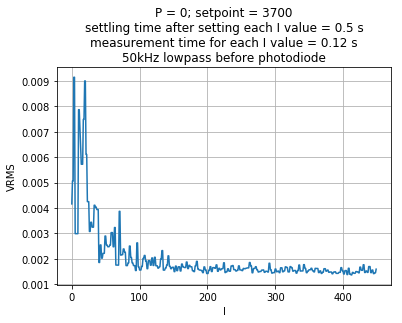

In [128]:
# get data from HDF file
dset = f["laser power vs I7"]
I_arr, VRMS_arr = dset[0], dset[1]

# plot labels
plt.xlabel("I")
plt.ylabel("VRMS")
plt.title(
    "P = " + str(dset.attrs["P"]) + "; "\
    "setpoint = " + str(dset.attrs["S"]) + "\n"\
    "settling time after setting each I value = " + str(dset.attrs["settling_time"]) + " s\n" + \
    "measurement time for each I value = " + str(12*dset.attrs["scope_horiz_scale"]) + " s\n" + \
    dset.attrs['setup_comments']
  )

# plot data
plt.plot(I_arr[VRMS_arr<1e10], VRMS_arr[VRMS_arr<1e10])

# format
plt.grid()

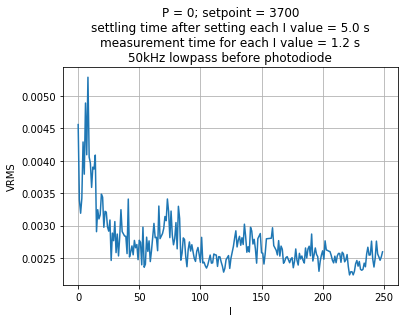

In [141]:
# get data from HDF file
dset = f["laser power vs I8"]
I_arr, VRMS_arr = dset[0], dset[1]

# plot labels
plt.xlabel("I")
plt.ylabel("VRMS")
plt.title(
    "P = " + str(dset.attrs["P"]) + "; "\
    "setpoint = " + str(dset.attrs["S"]) + "\n"\
    "settling time after setting each I value = " + str(round(dset.attrs["settling_time"], 2)) + " s\n" + \
    "measurement time for each I value = " + str(round(12*dset.attrs["scope_horiz_scale"], 2)) + " s\n" + \
    dset.attrs['setup_comments']
  )

# plot data
plt.plot(I_arr[VRMS_arr<1e10], VRMS_arr[VRMS_arr<1e10])

# format
plt.grid()

In [257]:
setup_comments = "50kHz lowpass before photodiode\n8dB attenuator at AD9910 output"

# measurement parameters
horiz_scale = 1
initial_sleep = 2.5
settling_time = 50*horiz_scale

# PID parameters
setpoint = 4500
KP = 100
KI = 0

# set the fixed values
set_scope_horizontal_scale(horiz_scale)
set_PID_param2('P', KP)
set_PID_param2('I', KI)
set_PID_param2('S', setpoint)
time.sleep(initial_sleep)

# execute the scan over one parameter
I_arr, VRMS_arr = [], []
accumulator_arr, error_arr, out_arr = [], [], []
for I in tqdm_notebook(range(0,250,10)):
    # set parameters
    I_arr.append(I)
    set_PID_param2('I', I)
    
    # wait for the settling time
    time.sleep(settling_time)
    
    # record and get data
    accumulator_arr.append( read_PID_output("accum.") )
    error_arr.append( read_PID_output("error") )
    out_arr.append( read_PID_output("out") )
    VRMS_arr.append(read_scope("VRMS", "CHAN1"))
    
# store data to HDF
dset = f.create_dataset("laser power vs I11", data=[I_arr, VRMS_arr, accumulator_arr, error_arr, out_arr])
dset.attrs['timestamp'] = time.time()
dset.attrs['row_names'] = "I, VRMS, accumulator, error, PID output"
dset.attrs['units'] = "integer, V, integer, integer, integer"
dset.attrs['scope_horiz_scale'] = horiz_scale
dset.attrs['settling_time'] = settling_time
dset.attrs['initial_sleep'] = initial_sleep
dset.attrs['P'] = KP
dset.attrs['I'] = KI
dset.attrs['S'] = setpoint
dset.attrs['setup_comments'] = setup_comments

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

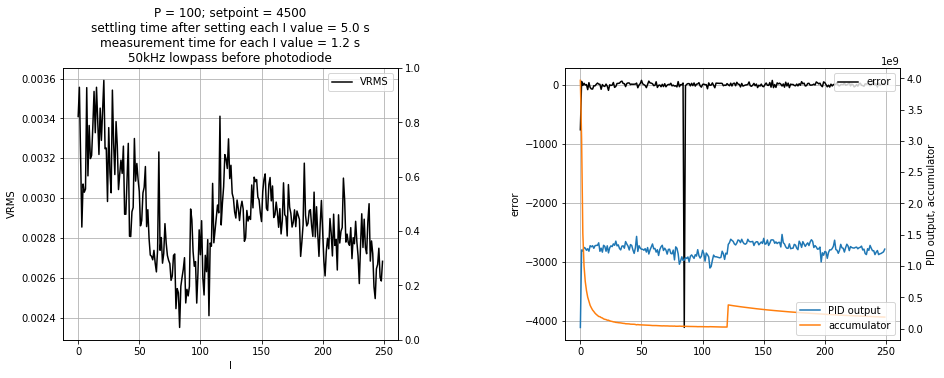

In [255]:
# get data from HDF file
dset = f["laser power vs I10"]
I_arr, VRMS_arr, accumulator_arr, error_arr, out_arr = dset[0], dset[1], dset[2], dset[3], dset[4]

# plot axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1_b = ax1.twinx()
ax2_b = ax2.twinx()

# plot labels
ax1.set_xlabel("I")
ax1.set_ylabel("VRMS")
ax1.set_title(
    "P = " + str(dset.attrs["P"]) + "; "\
    "setpoint = " + str(dset.attrs["S"]) + "\n"\
    "settling time after setting each I value = " + str(round(dset.attrs["settling_time"], 2)) + " s\n" + \
    "measurement time for each I value = " + str(round(12*dset.attrs["scope_horiz_scale"], 2)) + " s\n" + \
    dset.attrs['setup_comments']
  )
ax2.set_ylabel("error")
ax2_b.set_ylabel("PID output, accumulator")

# plot data
ax1.plot(I_arr[VRMS_arr<1e10], VRMS_arr[VRMS_arr<1e10], label="VRMS", color="black")
ax2.plot(I_arr[VRMS_arr<1e10], error_arr[VRMS_arr<1e10], label="error", color="black")
ax2_b.plot(I_arr[VRMS_arr<1e10], out_arr[VRMS_arr<1e10], label="PID output")
ax2_b.plot(I_arr[VRMS_arr<1e10], accumulator_arr[VRMS_arr<1e10], label="accumulator")

# format
plt.subplots_adjust(wspace=.5)
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend(loc=1)
ax2_b.legend(loc=4);

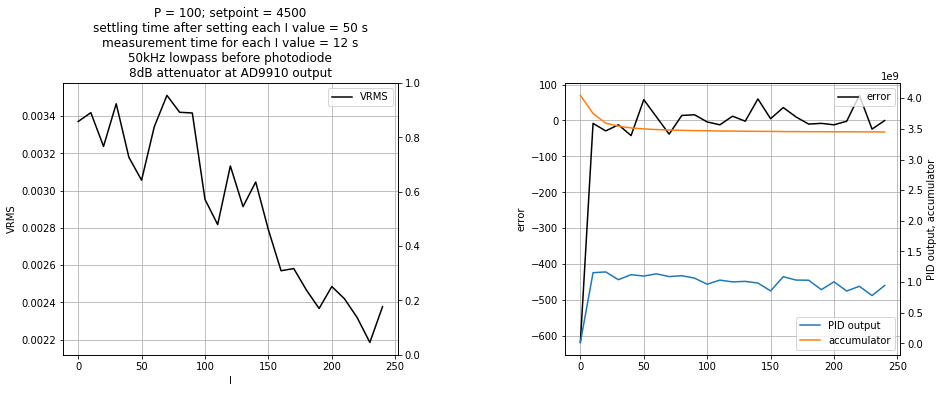

In [258]:
# get data from HDF file
dset = f["laser power vs I11"]
I_arr, VRMS_arr, accumulator_arr, error_arr, out_arr = dset[0], dset[1], dset[2], dset[3], dset[4]

# plot axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1_b = ax1.twinx()
ax2_b = ax2.twinx()

# plot labels
ax1.set_xlabel("I")
ax1.set_ylabel("VRMS")
ax1.set_title(
    "P = " + str(dset.attrs["P"]) + "; "\
    "setpoint = " + str(dset.attrs["S"]) + "\n"\
    "settling time after setting each I value = " + str(round(dset.attrs["settling_time"], 2)) + " s\n" + \
    "measurement time for each I value = " + str(round(12*dset.attrs["scope_horiz_scale"], 2)) + " s\n" + \
    dset.attrs['setup_comments']
  )
ax2.set_ylabel("error")
ax2_b.set_ylabel("PID output, accumulator")

# plot data
ax1.plot(I_arr[VRMS_arr<1e10], VRMS_arr[VRMS_arr<1e10], label="VRMS", color="black")
ax2.plot(I_arr[VRMS_arr<1e10], error_arr[VRMS_arr<1e10], label="error", color="black")
ax2_b.plot(I_arr[VRMS_arr<1e10], out_arr[VRMS_arr<1e10], label="PID output")
ax2_b.plot(I_arr[VRMS_arr<1e10], accumulator_arr[VRMS_arr<1e10], label="accumulator")

# format
plt.subplots_adjust(wspace=.5)
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend(loc=1)
ax2_b.legend(loc=4);

Define functions for scope coupling and offset values:

In [262]:
def set_scope_coupling(ch="CHAN1", coupling="DC"):
    scope.write(":"+ch+":COUP "+coupling)

def set_scope_DC_offset(ch="CHAN1", offs=0):
    scope.write(":"+ch+":OFFS "+str(offs))
    
def query_scope_offset(ch="CHAN1"):
    return scope.query(":"+ch+":OFFS?")

#### Scan proportional constant

In [166]:
setup_comments = "50kHz lowpass before photodiode"

# measurement parameters
horiz_scale = 0.01
initial_sleep = 2.5
settling_time = 50*horiz_scale

# PID parameters
setpoint = 3700
KP = 0
KI = 100

# set the fixed values
set_scope_horizontal_scale(horiz_scale)
set_PID_param2('P', KP)
set_PID_param2('I', KI)
set_PID_param2('S', setpoint)
time.sleep(initial_sleep)

# execute the scan over one parameter
P_arr, VRMS_arr = [], []
for P in tqdm_notebook(range(0,250)):
    P_arr.append(P)
    set_PID_param2('P', P)
    time.sleep(settling_time)
    VRMS_arr.append(read_scope("VRMS", "CHAN1"))
    
# store data to HDF
dset = f.create_dataset("laser power vs P3", data=[P_arr, VRMS_arr])
dset.attrs['timestamp'] = time.time()
dset.attrs['row_names'] = "P, VRMS"
dset.attrs['units'] = "integer, V"
dset.attrs['scope_horiz_scale'] = horiz_scale
dset.attrs['settling_time'] = settling_time
dset.attrs['initial_sleep'] = initial_sleep
dset.attrs['P'] = KP
dset.attrs['I'] = KI
dset.attrs['S'] = setpoint
dset.attrs['setup_comments'] = setup_comments

HBox(children=(IntProgress(value=0, max=250), HTML(value='')))

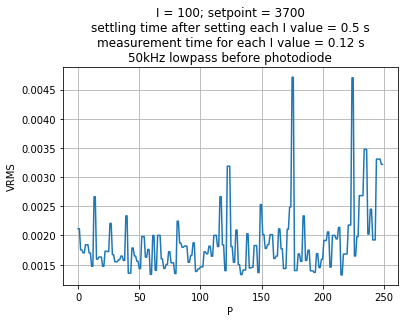

In [167]:
# get data from HDF file
dset = f["laser power vs P3"]
P_arr, VRMS_arr = dset[0], dset[1]

# plot labels
plt.xlabel("P")
plt.ylabel("VRMS")
plt.title(
    "I = " + str(dset.attrs["I"]) + "; "\
    "setpoint = " + str(dset.attrs["S"]) + "\n"\
    "settling time after setting each I value = " + str(dset.attrs["settling_time"]) + " s\n" + \
    "measurement time for each I value = " + str(12*dset.attrs["scope_horiz_scale"]) + " s\n" + \
    dset.attrs['setup_comments']
  )

# plot data
plt.plot(P_arr, VRMS_arr)

# format
plt.grid()

### FFT measurements

Define the scope function to setup the FFT:

In [259]:
def set_scope_FFT(active=True, hscale=50000, hcen=10000000):
    # parameter sanity check
    if type(active) != bool:
        print("ERROR: incorrect parameter type.")
        return
    if hscale<0 or hcen<0:
        print("ERROR: incorrect parameter value.")
        return
    
    # compose the list of FFT settings
    FFT_settings = [
       ":MATH:DISP " + str(int(active)), # enable or disable the math operation function
       ":MATH:OPER FFT", # set the operation to FFT
       ":MATH:SOUR1 CHAN1", # set the FFT input from CH1
       ":MATH:SCAL 1", # set vertical scale to 1V
       ":MATH:OFFS 0", # set offset to 0
       ":MATH:INV OFF", # do not invert the result
       ":MATH:FFT:SOUR CHAN1", # take FFT of CH1
       ":MATH:FFT:WIND RECT", # set the rectangle windowing function of the FFT
       ":MATH:FFT:UNIT DB", # set the vertical unit of FFT to decibels
       ":MATH:FFT:HSC "+str(hscale), # set the horizontal scale of FFT result to 500kHz
       ":MATH:FFT:HCEN "+str(hcen), # set the center frequency of FFT result to 10MHz
       ":MATH:FFT:MODE TRAC", # take FFT of the currently displayed waveform
     ]
    
    # record and return the FFT settings
    for setting in FFT_settings:
        scope.write(setting)
        
    return FFT_settings

Define the function to read the scope waveform:

In [ ]:
def read_waveform(ch="CHAN1"):
    # set the waveform settings
    read_settings = [
        ":WAV:SOUR "+ch, # set source
        ":WAV:MODE NORM", # normal mode (read the waveform data displayed on the screen)
        ":WAV:FORM ASC", # return ascii values
      ]
    for setting in read_settings:
        scope.write(setting)
    
    # read the waveform and its preample (metadata)
    data = scope.query(":WAV:DATA?")
    pre = scope.query(":WAV:PRE?")
    
    return [data,pre]

Test the above two functions:

In [ ]:
set_scope_FFT(active=True, hscale=50000, hcen=10000000)
data,pre = read_waveform(ch="MATH")
print(data)
print(pre)

Before taking more data, check that the PID is set correctly:

In [ ]:
# set AD9910 for amplitude control, and set TxENABLE to high
set_F(0+4)

# set PID parameters
set_PID_param2('P', 0)
set_PID_param2('I', 100)
set_PID_param2('S', 4500)

read_all_PID_outs()